<a href="https://colab.research.google.com/github/Philip-Cho/BitaminProject_Loan-Classification/blob/master/Loan_Prediction_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive


import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy.stats import mode

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/datasets/kaggle Loan Prediction(복습플젝)/df1_loan 2.csv')
data.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,$5849.0
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,$6091.0
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,$3000.0
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,$4941.0
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,$6000.0


In [4]:
# input / output split + 불필요한 feature 삭제
X = data.drop(['Unnamed: 0', 'Loan_ID', 'Loan_Status'], axis=1)
y = data['Loan_Status']

# Total_Income float 변환, Credit_history object 변환
for i in range(len(X['Total_Income'])):
    X['Total_Income'][i] = X['Total_Income'][i].strip('$')

X['Credit_History'].fillna(mode(X['Credit_History'])[0][0], inplace=True)
X = X.astype({'Total_Income':'float', 'Credit_History':'str'})
    

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             491 non-null    object 
 1   Married            497 non-null    object 
 2   Dependents         488 non-null    object 
 3   Education          500 non-null    object 
 4   Self_Employed      473 non-null    object 
 5   ApplicantIncome    500 non-null    int64  
 6   CoapplicantIncome  500 non-null    float64
 7   LoanAmount         482 non-null    float64
 8   Loan_Amount_Term   486 non-null    float64
 9   Credit_History     500 non-null    object 
 10  Property_Area      500 non-null    object 
 11  Total_Income       500 non-null    float64
dtypes: float64(4), int64(1), object(7)
memory usage: 47.0+ KB


# Methods

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('\n정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nF1: {3:.4f}\nROC: {3:.4f}'.format(accuracy, precision, recall, f1, roc_score))


def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds  = roc_curve(y_test, pred_proba_c1)
    
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()

def precision_recall_curve_plot(y_test, pred_proba_c1):

    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: thresholds_boundary], linestyle= '--', label='precision')
    plt.plot(thresholds, recalls[0: thresholds_boundary], label='recall')
    
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))

    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
# 결측치 처리1 - 평균(수치형), 최빈값(범주형) 처리
def meanMode(X):
    
    # 연속형 피처 리스트 저장
    num_col = list(X._get_numeric_data().columns)

    # 범주형 피처 리스트 저장
    cat_col = list(X.columns)
    for col in num_col:
        cat_col.remove(col)

    # 연속형 데이터 전처리(평균값으로 채우기)
    for col in num_col:
        X[col].fillna(round(np.mean(X[col])), inplace=True)

    # 범주형 데이터 전처리 (최빈값으로 채우기)
    for col in cat_col:
        X[col].fillna(mode(X[col])[0][0], inplace=True)
        
    return X
        
    
# 결측치 처리2 - 결측행 제거
def delNaN(X, y):
    X['y'] = y
    X = X.dropna(how='any', axis=0).reset_index()
    return X.drop('y', axis=1), X['y']


    # 인코딩1 - 레이블인코딩
def LabelEncode(X):
    
    # 연속형 피처 리스트 저장
    num_col = list(X._get_numeric_data().columns)

    # 범주형 피처 리스트 저장
    cat_col = list(X.columns)
    for col in num_col:
        cat_col.remove(col)
        
    encoder = LabelEncoder()
    for cat in cat_col:
        X[cat] = encoder.fit_transform(X[cat])

    return X

# 인코딩2 - 원핫인코딩
def OneHotEncode(X):
    object_col = []
    for col in X.columns:
        if X[col].dtype == 'object':
            object_col.append(col)

    enc = OneHotEncoder()
    enc.fit(X.loc[:,object_col])

    onehot_X = pd.DataFrame(enc.transform(X.loc[:,object_col]).toarray(), 
                                   columns = enc.get_feature_names(object_col))
    X.drop(object_col, axis=1, inplace=True)
    X = pd.concat([X, onehot_X], axis=1)
    
    return X


# Preprocess

In [8]:
X = meanMode(X)
# X,y = delNaN(X,y)


In [9]:
# 가계 부채비율
X['DeptRatio'] = round((X['LoanAmount']*1000)/(X['Total_Income']*12),1)

# 월 이자 부담(원금 균등상환 전제)
montly_interest = round(X['LoanAmount']*1000/X['Loan_Amount_Term'])
X['MonthlyInterest'] = round(montly_interest/X['Total_Income'],2)

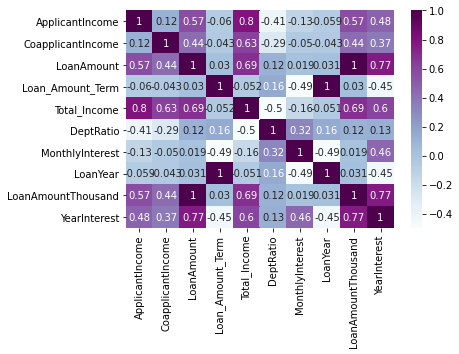

In [10]:
X['LoanYear'] = (X['Loan_Amount_Term']/12).astype(int)
X['LoanAmountThousand'] = X['LoanAmount']*1000
X['YearInterest'] = X['LoanAmountThousand']/X['LoanYear']

X['ApplicantIncome'] = np.log(X['ApplicantIncome'])
X['CoapplicantIncome'] = np.log(X['CoapplicantIncome'])
X['Total_Income'] = np.log(X['Total_Income'])
X['YearInterest'] = np.log(X['YearInterest'])

corr2 = X.corr()
sns.heatmap(corr2, annot=True, cmap='BuPu')

In [11]:
# X = X.drop(['LoanAmount', 'LoanAmountThousand', 'Loan_Amount_Term', 'CoapplicantIncome'],axis=1)
# X = X.drop(['LoanAmount', 'LoanAmountThousand', 'Loan_Amount_Term', 'CoapplicantIncome', 'LoanYear'],axis=1)
# X = X.drop(['LoanAmountThousand', 'LoanYear', 'CoapplicantIncome'],axis=1)
# X = X.drop(['CoapplicantIncome'],axis=1)

X = X.drop(['LoanAmountThousand', 'LoanYear', 'CoapplicantIncome', 'YearInterest'],axis=1)


In [12]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,DeptRatio,MonthlyInterest
0,Male,No,0,Graduate,No,8.674026,144.0,360.0,1.0,Urban,8.674026,2.1,0.07
1,Male,Yes,1,Graduate,No,8.430109,128.0,360.0,1.0,Rural,8.714568,1.8,0.06
2,Male,Yes,0,Graduate,Yes,8.006368,66.0,360.0,1.0,Urban,8.006368,1.8,0.06
3,Male,Yes,0,Not Graduate,No,7.856707,120.0,360.0,1.0,Urban,8.505323,2.0,0.07
4,Male,No,0,Graduate,No,8.699515,141.0,360.0,1.0,Urban,8.699515,2.0,0.07


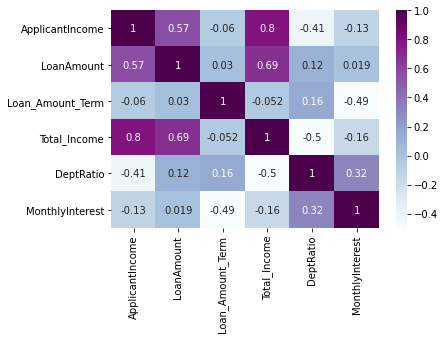

In [13]:
corr3 = X.corr()
sns.heatmap(corr3, annot=True, cmap='BuPu')

In [14]:
X = LabelEncode(X)
enc = LabelEncoder()
y = enc.fit_transform(y)

# Resampling

In [15]:
# from imblearn.over_sampling import RandomOverSampler
# from collections import Counter

# randomsample= RandomOverSampler()
# X, y = randomsample.fit_resample(X, y)
# X = pd.DataFrame(X)
# y = pd.Series(y)

# [Resampling 진행 시 결과]
# LogisticRegression  :  0.6984592468463435
# LGBMClassifier  :  0.8839780291393193
# CatBoostClassifier  :  0.8695712889261277
# DecisionTreeClassifier  :  0.8377321603128053
# SVC  :  0.562281804217288
# XGBClassifier  :  0.8014243820695434

# Model Building

In [16]:
from sklearn.model_selection import StratifiedKFold

def kFold(model):
    n_fold = 11

    skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=156)
    folds = []
    acc_list = []

    for train_idx, validate_idx in skfold.split(X,y):
        folds.append((train_idx, validate_idx))

    for fold in range(n_fold):
    #     print(f'\n---------------- Fold{fold}----------------\n')
        train_idx, validate_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[validate_idx], y[train_idx], y[validate_idx]

        kf_model = model
        kf_model.fit(X_train, y_train)

        y_preds = kf_model.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_preds)
    #     print('Accuracy Score: {:0.3f}'.format(accuracy))
        acc_list.append(accuracy)


#     print(np.mean(acc_list))
    return np.mean(acc_list)

# Logistic = 0.810
# catboost: 0.816

In [17]:
# !pip install --target=$my_path catboost

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# models = [DecisionTreeClassifier(), KNeighborsClassifier(), SVC(), XGBClassifier()]
models = [LogisticRegression(), LGBMClassifier(n_estimators=1000, random_state=2),
        CatBoostClassifier(n_estimators=1000, random_state=2, verbose=False),
        DecisionTreeClassifier(min_samples_split=3),
        XGBClassifier(learning_rate =0.002,
                      n_estimators=1000,
                      max_depth=6,
                      min_child_weight=1,
                      gamma=0.2,
                      subsample=0.69,
                      colsample_bytree=0.8,
                      objective= 'binary:logistic',
                      nthread=-1,
                      scale_pos_weight=1,
                      reg_alpha=1e-5,
                      seed=10,
                      verbose=False)]

for model in models:
    print(model.__class__.__name__,' : ', kFold(model))


LogisticRegression  :  0.8101010101010101
LGBMClassifier  :  0.7862099253403602
CatBoostClassifier  :  0.8260869565217391
DecisionTreeClassifier  :  0.6858585858585858
XGBClassifier  :  0.8220904699165569


# Model Evaluation